1. Train the model with Signal(NMSSM) and $\gamma\gamma$+Jets and gJets 

In [1]:
import pandas as pd
import uproot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [9]:
# File paths
signal_files_lowX_lowY = [
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X650_Y95/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X650_Y100/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X650_Y125/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X650_Y95/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X700_Y100/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X700_Y125/preselection"),
#     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X700_Y80/preselection"),
#     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X700_Y90/preselection"),
#     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X550_Y80/preselection"),
#     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X550_Y90/preselection"),
# #     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X550_Y95/preselection"),
# #     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X550_Y100/preselection"),
]

background_files = [
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/GGJets/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/GJetPt20To40/preselection"),
    ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/GJetPt40/preselection"),
]

In [11]:
# Columns to be loaded
keys = [
     'dibjet_pt', 'diphoton_pt', 'bbgg_pt', 'bbgg_eta', 'bbgg_phi',
    'lead_pho_phi', 'sublead_pho_eta', 'sublead_pho_phi', 'diphoton_eta', 
    'diphoton_phi', 'dibjet_eta', 'dibjet_phi', 'lead_bjet_pt', 'sublead_bjet_pt', 
    'lead_bjet_eta', 'lead_bjet_phi', 'sublead_bjet_eta', 'sublead_bjet_phi', 
    'sublead_bjet_PNetB', 'lead_bjet_PNetB', 'CosThetaStar_gg', 'CosThetaStar_jj', 
    'CosThetaStar_CS', 'DeltaR_jg_min',   'pholead_PtOverM', 'phosublead_PtOverM',
    'weight_preselection',
]
# Variables removed :- 'bbgg_mass','FirstJet_PtOverM', 'SecondJet_PtOverM', 'diphoton_bbgg_mass', 'dibjet_bbgg_mass', 'lead_pho_eta',

## Add 

In [16]:
# Load DataFrames
dfs = {}

# Load signal files
for file, key in signal_files_lowX_lowY:
    try:
        with uproot.open(file) as f:
            dfs[key] = f[key].arrays(keys, library="pd")
    except Exception as e:
        print(f"Error loading {file} with key {key}: {e}")

# Load background files
for file, key in background_files:
    try:
        with uproot.open(file) as f:
            dfs[key] = f[key].arrays(keys, library="pd")
    except Exception as e:
        print(f"Error loading {file} with key {key}: {e}")

# Combine signal DataFrames
signal_df = pd.concat([dfs[key] for key in dfs if 'NMSSM' in key], ignore_index=True)
background_df = pd.concat([dfs[key] for key in dfs if 'GJet' in key or 'GGJets' in key], ignore_index=True)



# signal_df = pd.concat([])
# Print combined sample sizes
print(f'Total Signal Shape: {signal_df.shape}')
print(f'Total Background Shape: {background_df.shape}')


Total Signal Shape: (135416, 27)
Total Background Shape: (98635, 27)


In [18]:
# Assign labels to signal and background classes
signal_df['label'] = 0  # Signal class

# Assign background labels based on the key
dfs["/GGJets/preselection"]['label'] = 1  # Background class 1
dfs["/GJetPt20To40/preselection"]['label'] = 2  # Background class 2
dfs["/GJetPt40/preselection"]['label'] = 2  # Background class 2

# Combine signal and all background dataframes into one DataFrame
combined_df = pd.concat([signal_df, dfs["/GGJets/preselection"], dfs["/GJetPt20To40/preselection"], dfs["/GJetPt40/preselection"]], ignore_index=True)


In [20]:
# dfs = {}

# # Loop through each file and load the corresponding dataframe
# for file, key in files:
#     with uproot.open(file) as f:
#         dfs[key] = f[key].arrays(keys, library="pd")

# signal_df_1 = dfs["/NMSSM_X300_Y60/preselection"]
# signal_df_2 = dfs["/NMSSM_X400_Y80/preselection"]
# background_df_1 = dfs["/GGJets/preselection"]
# background_df_2 = dfs["/GJetPt20To40/preselection"]
# background_df_3 = dfs["/GJetPt40/preselection"]

# print('singal df NMSSM_X300_Y60', signal_df_1.shape)
# print('singal df NMSSM_X400_Y80', signal_df_2.shape)
# print('background_df_1 ', background_df_1.shape)
# print('background_df_2', background_df_2.shape)
# print('background_df_3 ', background_df_3.shape)

# background_df = pd.concat([background_df_1, background_df_2, background_df_3], ignore_index=True)
# print('background_df', background_df.shape)

# signal_df_1['label'] = 1
# signal_df_2['label'] = 2
# background_df['label'] = 0

# combined_df = pd.concat([signal_df_1, signal_df_2, background_df], ignore_index=True)
# print('combined dataframe', combined_df.shape)

# features = [
#     # 'diphoton_mass',
# #     'dibjet_mass',
#     # 'lead_pho_pt',
#     # 'sublead_pho_pt',
#     'bbgg_eta',
#     'bbgg_phi',
#     'bbgg_mass',
#     'lead_pho_eta',
#     'lead_pho_phi',
#     'sublead_pho_eta',
#     'sublead_pho_phi',
#     'diphoton_eta',
#     'diphoton_phi',
#     'dibjet_eta',
#     'dibjet_phi',
#     'lead_bjet_pt',
#     'sublead_bjet_pt',
#     'lead_bjet_eta',
#     'lead_bjet_phi',
#     'sublead_bjet_eta',
#     'sublead_bjet_phi',
#     'sublead_bjet_PNetB',
#     'lead_bjet_PNetB',
#     'CosThetaStar_gg',
#     'CosThetaStar_jj',
#     'CosThetaStar_CS',
#     'DeltaR_jg_min',
#     'pholead_PtOverM',
#     'phosublead_PtOverM',
#     'FirstJet_PtOverM',
#     'SecondJet_PtOverM',
#     # 'lead_pt_over_diphoton_mass',
#     # 'sublead_pt_over_diphoton_mass',
#     # 'lead_pt_over_dibjet_mass',
#     # 'sublead_pt_over_dibjet_mass',
#     'diphoton_bbgg_mass',
#     'dibjet_bbgg_mass',
# ]

In [21]:
# X = combined_df[features]
# y = combined_df['label']
# weight = combined_df['weight_preselection']
# print(weight.shape)

# imputer = SimpleImputer(strategy='mean')
# X_imputed = imputer.fit_transform(X)

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_imputed)

# X_train, X_test, y_train, y_test = train_test_split(combined_df[features], combined_df['label'], test_size=0.2, random_state=42, stratify=combined_df['label'])

In [22]:

X = combined_df[features]
y = combined_df['label']
weights = combined_df['weight_preselection']

# Impute missing values and scale the data
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Extract weights for train and test datasets
X_train_weights = combined_df.loc[X_train.index, 'weight_preselection']
X_test_weights = combined_df.loc[X_test.index, 'weight_preselection']

# Impute and scale the features
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [23]:
# Extract the weights for train and test datasets
X_train_weights = combined_df.loc[X_train.index, 'weight_preselection']
X_test_weights = combined_df.loc[X_test.index, 'weight_preselection']

# Impute and scale the features
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
X_train_weights_tensor = torch.tensor(X_train_weights.values, dtype=torch.float32)
X_test_weights_tensor = torch.tensor(X_test_weights.values, dtype=torch.float32)

# Create TensorDataset and DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor, X_train_weights_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor, X_test_weights_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report

class SimpleDNN(nn.Module):
    def __init__(self, input_dim, n_classes):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, n_classes)  # Output layer for n_classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # Output logits for each class
        return x

criterion = nn.CrossEntropyLoss(reduction='mean')  # Use 'mean' for standard loss computation

def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()
    epoch_losses = []
    epoch_accuracies = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        
        for inputs, labels, weights in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)  # CrossEntropyLoss expects raw logits
            
            if weights is not None:  # Apply weights if provided
                weighted_loss = (loss * weights).mean()
            else:
                weighted_loss = loss.mean()
            
            weighted_loss.backward()
            optimizer.step()
            
            running_loss += weighted_loss.item() * inputs.size(0)
            
            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_preds / total_preds
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    
    return epoch_losses, epoch_accuracies

def evaluate_model(model, test_loader, criterion):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels, _ in test_loader:  # Assuming weights are not needed for evaluation
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(preds.tolist())
    
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_true, y_pred, target_names=["Background", "Signal 1", "Signal 2"]))
    
    return accuracy


In [25]:
# Define the number of classes and input dimensions
n_classes = 3  # Three classes: Background, Signal 1, Signal 2
input_dim = X_train_scaled.shape[1]  # Number of features in your input data

# Instantiate the model
model = SimpleDNN(input_dim, n_classes)

# Define the loss function (reduction='none' if you are using sample weights)
criterion = nn.CrossEntropyLoss(reduction='none')

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model and get losses and accuracies
losses, accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=20)  # Adjust num_epochs as needed


Epoch 1/20, Loss: 0.3360, Accuracy: 0.8210
Epoch 2/20, Loss: 0.3222, Accuracy: 0.8346
Epoch 3/20, Loss: 0.3191, Accuracy: 0.8374
Epoch 4/20, Loss: 0.3169, Accuracy: 0.8395
Epoch 5/20, Loss: 0.3152, Accuracy: 0.8410
Epoch 6/20, Loss: 0.3136, Accuracy: 0.8413
Epoch 7/20, Loss: 0.3122, Accuracy: 0.8432
Epoch 8/20, Loss: 0.3115, Accuracy: 0.8435
Epoch 9/20, Loss: 0.3105, Accuracy: 0.8431
Epoch 10/20, Loss: 0.3097, Accuracy: 0.8443
Epoch 11/20, Loss: 0.3092, Accuracy: 0.8456
Epoch 12/20, Loss: 0.3083, Accuracy: 0.8455
Epoch 13/20, Loss: 0.3077, Accuracy: 0.8454
Epoch 14/20, Loss: 0.3070, Accuracy: 0.8455
Epoch 15/20, Loss: 0.3061, Accuracy: 0.8461
Epoch 16/20, Loss: 0.3056, Accuracy: 0.8461
Epoch 17/20, Loss: 0.3052, Accuracy: 0.8463
Epoch 18/20, Loss: 0.3049, Accuracy: 0.8472
Epoch 19/20, Loss: 0.3043, Accuracy: 0.8476
Epoch 20/20, Loss: 0.3038, Accuracy: 0.8475


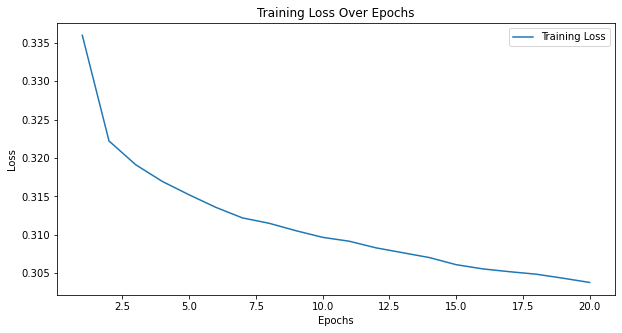

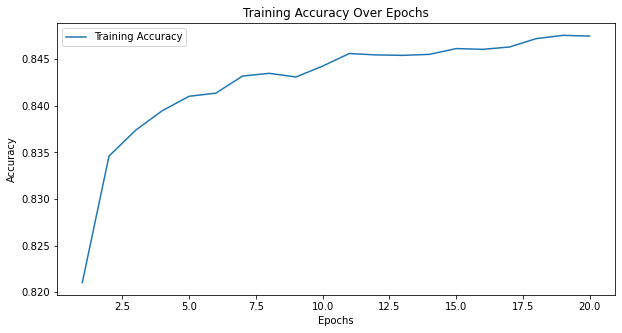

In [26]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(losses) + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.show()


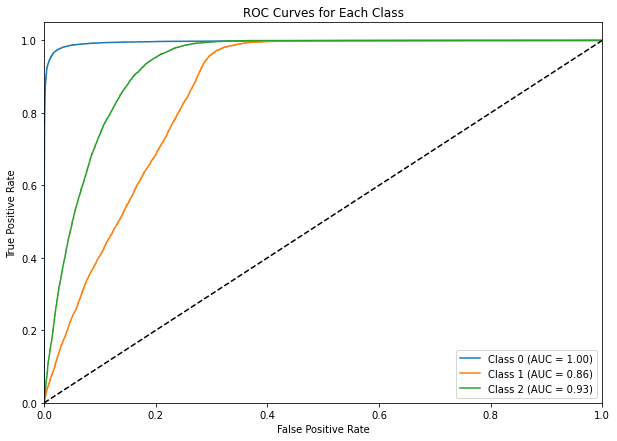

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC calculation (one-vs-rest)
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Predict probabilities on the test set
model.eval()
y_score = []
with torch.no_grad():
    for inputs, _, _ in test_loader:
        outputs = model(inputs)
        y_score.extend(outputs.numpy())

y_score = np.array(y_score)

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 7))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.show()


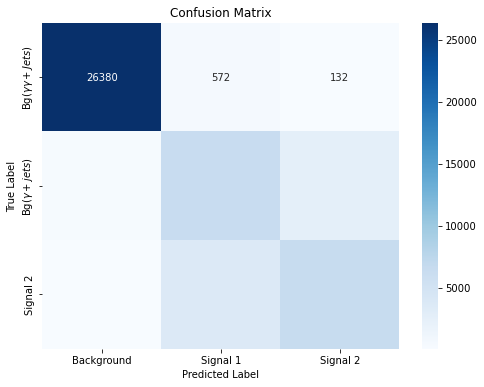

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate predictions
y_pred = []
with torch.no_grad():
    for inputs, _, _ in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Background", "Signal 1", "Signal 2"], yticklabels=["Bg($\gamma\gamma+Jets$)", "Bg($\gamma+jets$)", "Signal 2"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Classifier output 

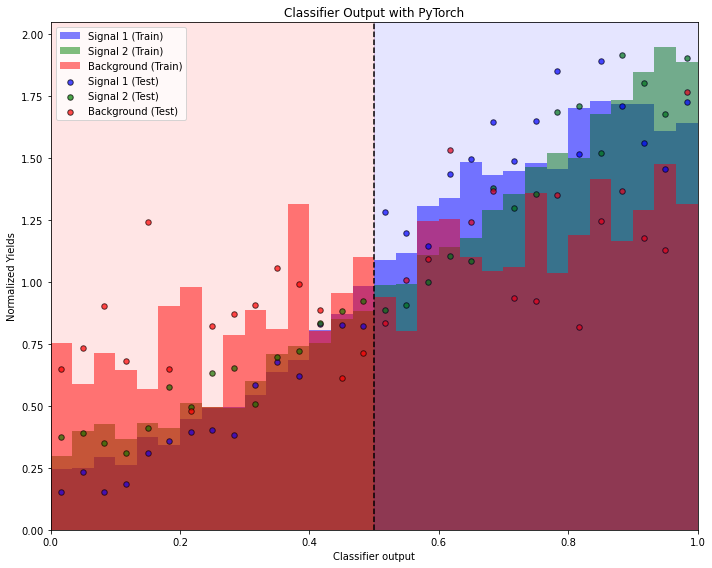

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to get predictions from the PyTorch model
def get_predictions(loader, model):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels, _ in loader:
            outputs = model(inputs)
            outputs = outputs.squeeze()
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions for training and test data
train_preds, train_true = get_predictions(train_loader, model)
test_preds, test_true = get_predictions(test_loader, model)

# Convert weights tensors to NumPy arrays
X_train_weights_np = X_train_weights_tensor.numpy()
X_test_weights_np = X_test_weights_tensor.numpy()

# Define bins
bins = np.linspace(0, 1, 31)

# Plot histograms for training data
plt.figure(figsize=(10, 8))

# Plot Signal 1 (train)
plt.hist(train_preds[train_true == 1][:, 1], bins=bins, color='blue', alpha=0.5, label='Signal 1 (Train)', density=True, weights=X_train_weights_np[train_true == 1])

# Plot Signal 2 (train)
plt.hist(train_preds[train_true == 2][:, 2], bins=bins, color='green', alpha=0.5, label='Signal 2 (Train)', density=True, weights=X_train_weights_np[train_true == 2])

# Plot Background (train)
plt.hist(train_preds[train_true == 0][:, 0], bins=bins, color='red', alpha=0.5, label='Background (Train)', density=True, weights=X_train_weights_np[train_true == 0])

# Calculate histograms for test data
test_hist_s1, _ = np.histogram(test_preds[test_true == 1][:, 1], bins=bins, density=True, weights=X_test_weights_np[test_true == 1])
test_hist_s2, _ = np.histogram(test_preds[test_true == 2][:, 2], bins=bins, density=True, weights=X_test_weights_np[test_true == 2])
test_hist_b, _ = np.histogram(test_preds[test_true == 0][:, 0], bins=bins, density=True, weights=X_test_weights_np[test_true == 0])

# Calculate bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot scatter points for test data
plt.scatter(bin_centers, test_hist_s1, color='blue', alpha=0.7, label='Signal 1 (Test)', marker='o', s=30, edgecolor='k')
plt.scatter(bin_centers, test_hist_s2, color='green', alpha=0.7, label='Signal 2 (Test)', marker='o', s=30, edgecolor='k')
plt.scatter(bin_centers, test_hist_b, color='red', alpha=0.7, label='Background (Test)', marker='o', s=30, edgecolor='k')

# Add background colors
plt.axvspan(0, 0.5, color='red', alpha=0.1)
plt.axvspan(0.5, 1, color='blue', alpha=0.1)

plt.axvline(0.5, color='k', linestyle='--')
plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.xlim(0, 1)
plt.legend()
plt.title('Classifier Output with PyTorch')

# Save and display the plot
# plt.savefig("bdtplots/dnn/classifier_output_plot.png")
# plt.savefig("bdtplots/dnn/classifier_output_plot.pdf")
plt.tight_layout()
plt.show()


Total test_preds shape: (46811, 3)
Total test_true shape: (46811,)
Total weights shape: (46811,)
Signal 1 predictions shape: (9360,)
Signal 1 weights shape: (9360,)
Background predictions shape: (27084,)
Background weights shape: (27084,)


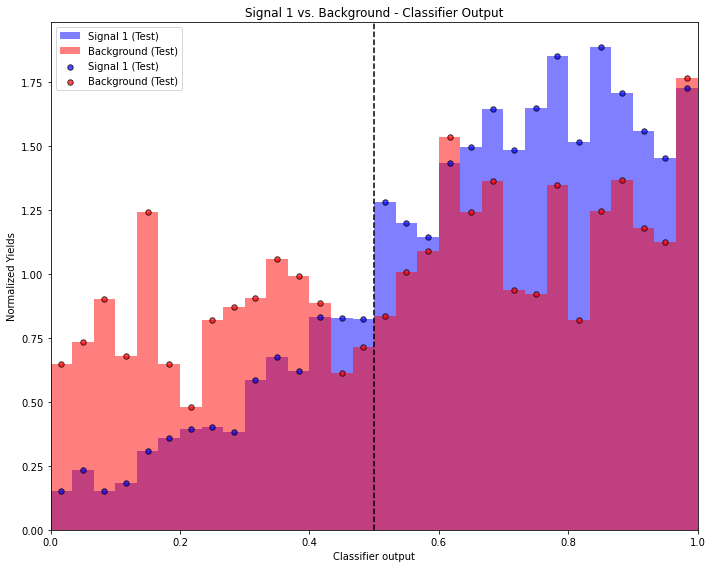

Signal 2 predictions shape: (10367,)
Signal 2 weights shape: (10367,)


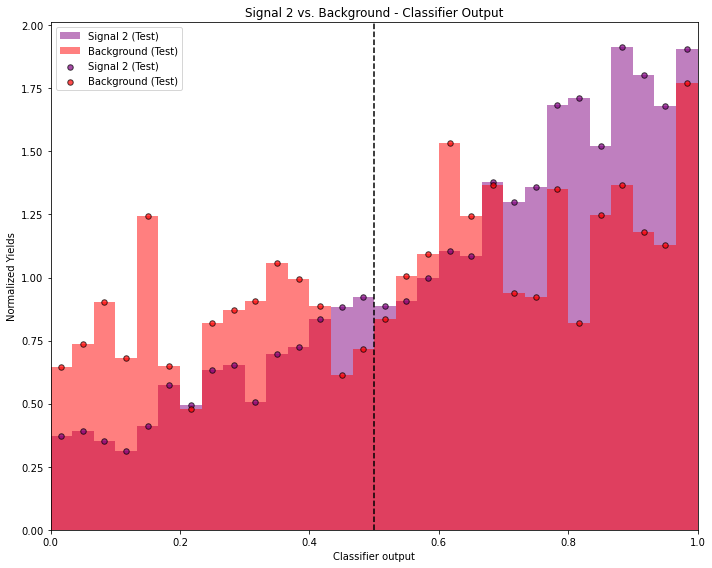

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to get predictions from the PyTorch model
def get_predictions(loader, model):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels, _ in loader:
            outputs = model(inputs)
            outputs = outputs.squeeze()
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions for test data
test_preds, test_true = get_predictions(test_loader, model)

# Convert weights tensors to NumPy arrays
X_test_weights_np = X_test_weights_tensor.numpy()

# Define bins
bins = np.linspace(0, 1, 31)

# Helper function to safely filter arrays
def safe_filter(arr, condition):
    return arr[condition]

# Diagnostics: Print the shapes before and after filtering
print("Total test_preds shape:", test_preds.shape)
print("Total test_true shape:", test_true.shape)
print("Total weights shape:", X_test_weights_np.shape)

# Signal 1 vs. Background
plt.figure(figsize=(10, 8))

# Filter predictions and weights
sig1_preds = safe_filter(test_preds[:, 1], test_true == 1)  # Select the column corresponding to Signal 1
sig1_weights = safe_filter(X_test_weights_np, test_true == 1)

# Diagnostics: Print shapes after filtering
print("Signal 1 predictions shape:", sig1_preds.shape)
print("Signal 1 weights shape:", sig1_weights.shape)

# Check shapes to avoid errors
assert sig1_preds.shape == sig1_weights.shape, f"Mismatch in Signal 1 shapes! Preds shape: {sig1_preds.shape}, Weights shape: {sig1_weights.shape}"

# Background filtering
bg_preds = safe_filter(test_preds[:, 0], test_true == 0)  # Select the column corresponding to Background
bg_weights = safe_filter(X_test_weights_np, test_true == 0)

# Diagnostics: Print shapes after filtering
print("Background predictions shape:", bg_preds.shape)
print("Background weights shape:", bg_weights.shape)

# Check shapes to avoid errors
assert bg_preds.shape == bg_weights.shape, f"Mismatch in Background shapes! Preds shape: {bg_preds.shape}, Weights shape: {bg_weights.shape}"

# Histograms for Signal 1 and Background in the test data
test_hist_s1, _ = np.histogram(sig1_preds, bins=bins, density=True, weights=sig1_weights)
test_hist_b1, _ = np.histogram(bg_preds, bins=bins, density=True, weights=bg_weights)

# Plot histograms
plt.hist(sig1_preds, bins=bins, color='blue', alpha=0.5, label='Signal 1 (Test)', density=True, weights=sig1_weights)
plt.hist(bg_preds, bins=bins, color='red', alpha=0.5, label='Background (Test)', density=True, weights=bg_weights)

# Plot scatter points
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.scatter(bin_centers, test_hist_s1, color='blue', alpha=0.7, label='Signal 1 (Test)', marker='o', s=30, edgecolor='k')
plt.scatter(bin_centers, test_hist_b1, color='red', alpha=0.7, label='Background (Test)', marker='o', s=30, edgecolor='k')

plt.axvline(0.5, color='k', linestyle='--')
plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.xlim(0, 1)
plt.legend()
plt.title('Signal 1 vs. Background - Classifier Output')

# Save and display the plot
# plt.savefig("bdtplots/dnn/classifier_output_signal1_vs_background.png")
# plt.savefig("bdtplots/dnn/classifier_output_signal1_vs_background.pdf")
plt.tight_layout()
plt.show()

# Signal 2 vs. Background
plt.figure(figsize=(10, 8))

# Filter predictions and weights for Signal 2
sig2_preds = safe_filter(test_preds[:, 2], test_true == 2)  # Select the column corresponding to Signal 2
sig2_weights = safe_filter(X_test_weights_np, test_true == 2)

# Diagnostics: Print shapes after filtering
print("Signal 2 predictions shape:", sig2_preds.shape)
print("Signal 2 weights shape:", sig2_weights.shape)

# Check shapes to avoid errors
assert sig2_preds.shape == sig2_weights.shape, f"Mismatch in Signal 2 shapes! Preds shape: {sig2_preds.shape}, Weights shape: {sig2_weights.shape}"

# Histograms for Signal 2 and Background in the test data
test_hist_s2, _ = np.histogram(sig2_preds, bins=bins, density=True, weights=sig2_weights)
test_hist_b2, _ = np.histogram(bg_preds, bins=bins, density=True, weights=bg_weights)

# Plot histograms
plt.hist(sig2_preds, bins=bins, color='purple', alpha=0.5, label='Signal 2 (Test)', density=True, weights=sig2_weights)
plt.hist(bg_preds, bins=bins, color='red', alpha=0.5, label='Background (Test)', density=True, weights=bg_weights)

# Plot scatter points
plt.scatter(bin_centers, test_hist_s2, color='purple', alpha=0.7, label='Signal 2 (Test)', marker='o', s=30, edgecolor='k')
plt.scatter(bin_centers, test_hist_b2, color='red', alpha=0.7, label='Background (Test)', marker='o', s=30, edgecolor='k')

plt.axvline(0.5, color='k', linestyle='--')
plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.xlim(0, 1)
plt.legend()
plt.title('Signal 2 vs. Background - Classifier Output')

# Save and display the plot
# plt.savefig("bdtplots/dnn/classifier_output_signal2_vs_background.png")
# plt.savefig("bdtplots/dnn/classifier_output_signal2_vs_background.pdf")
plt.tight_layout()
plt.show()
